In [1]:
import numpy as np
print(np.__version__)

import pandas as pd
print(pd.__version__)

import cv2
print(cv2.__version__)

import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

1.18.1
1.0.3
3.4.2
2.1.0


In [2]:
overview = pd.read_csv("D:/Data/the-simpsons-characters-dataset/number_pic_char.csv")
print(overview)

    Unnamed: 0                      name  total  train  test  bounding_box
0            0             Homer Simpson   2246   1909   337           612
1            1              Ned Flanders   1454   1236   218           595
2            2               Moe Szyslak   1452   1234   218           215
3            3              Lisa Simpson   1354   1151   203           562
4            4              Bart Simpson   1342   1141   201           554
5            5             Marge Simpson   1291   1097   194           557
6            6          Krusty The Clown   1206   1025   181           226
7            7         Principal Skinner   1194   1015   179           506
8            8  Charles Montgomery Burns   1193   1014   179           650
9            9       Milhouse Van Houten   1079    917   162           210
10          10              Chief Wiggum    986    838   148           209
11          11    Abraham Grampa Simpson    913    776   137           595
12          12           

In [3]:
data = np.loadtxt("D:/Data/the-simpsons-characters-dataset/annotation_windows.txt", dtype=str, delimiter=',')
print(data[:5])
# Data has shape: PATH, UPPER_LEFT_CORNER_X, UPPER_LEFT_CORNER_Y , LOWER_RIGHT_CORNER_X, LOWER_RIGHT_CORNER_Y, CHARACTER

[['characters/abraham_grampa_simpson/pic_0000.jpg' '57' '72' '52' '72'
  'abraham_grampa_simpson']
 ['characters/abraham_grampa_simpson/pic_0001.jpg' '80' '31' '337' '354'
  'abraham_grampa_simpson']
 ['characters/abraham_grampa_simpson/pic_0002.jpg' '128' '48' '285' '407'
  'abraham_grampa_simpson']
 ['characters/abraham_grampa_simpson/pic_0003.jpg' '72' '126' '158' '275'
  'abraham_grampa_simpson']
 ['characters/abraham_grampa_simpson/pic_0004.jpg' '123' '61' '294' '416'
  'abraham_grampa_simpson']]


In [4]:
print('Number of images:', len(data))

Number of images: 6752


In [5]:
np.random.seed(42)
np.random.shuffle(data)

In [6]:
# Map only the characters with given bounding boxes
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}
pic_size = 64
num_classes = len(map_characters)

In [10]:
# Load training data
x = []
y = []
for datapiece in data:
    for item in map_characters.items():
        if item[1] == datapiece[5]:
            temp = cv2.imread('D:/Data/the-simpsons-characters-dataset/' + datapiece[0])
            if temp is not None:
                x.append(cv2.resize(temp, (pic_size, pic_size)).astype('float32')/255)
                y.append(item[0])
x = np.array(x)
y = np.array(y)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [12]:
print(y_train[0])
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
print(y_train[0])

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
print('x_train length:', len(x_train))
print('y_train length:', len(y_train))
print('x_test length:', len(x_test))
print('y_test length:', len(y_test))

x_train length: 4704
y_train length: 4704
x_test length: 2016
y_test length: 2016


In [51]:
# create the CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 100
input_shape = (pic_size, pic_size, 3)

model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
            metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 64)       

In [52]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

datagen.fit(x_train)
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, mode='max')
callbacks_list = [checkpoint]
history=model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    validation_data=(x_test, y_test))

  ...
    to  
  ['...']
Train for 147 steps, validate on 2016 samples
Epoch 1/100
147/147 [==============================] - 8s 51ms/step - loss: 2.7415 - accuracy: 0.1237 - val_loss: 2.6276 - val_accuracy: 0.2088
Epoch 2/100
147/147 [==============================] - 6s 43ms/step - loss: 2.5096 - accuracy: 0.2164 - val_loss: 2.3516 - val_accuracy: 0.2966
Epoch 3/100
147/147 [==============================] - 7s 46ms/step - loss: 2.3435 - accuracy: 0.2727 - val_loss: 2.1835 - val_accuracy: 0.3318
Epoch 4/100
147/147 [==============================] - 6s 42ms/step - loss: 2.2318 - accuracy: 0.3191 - val_loss: 2.0548 - val_accuracy: 0.3780
Epoch 5/100
147/147 [==============================] - 6s 42ms/step - loss: 2.1285 - accuracy: 0.3478 - val_loss: 1.9010 - val_accuracy: 0.4182
Epoch 6/100
147/147 [==============================] - 6s 42ms/step - loss: 1.9979 - accuracy: 0.3958 - val_loss: 1.8492 - val_accuracy: 0.4613
Epoch 7/100
147/147 [==============================] - 7s 47ms/st

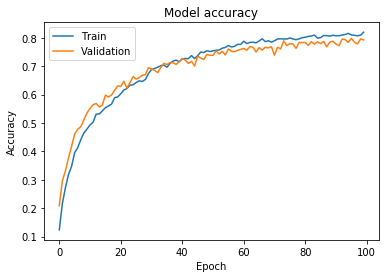

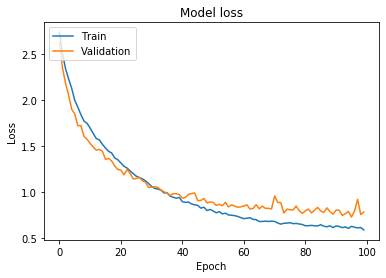

In [57]:
def plotHistory(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy']),
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
       
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plotHistory(history)

In [53]:
import glob, os
images = []
os.chdir('D:/Data/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/')
for image_path in glob.glob("*.jpg"):
    temp = cv2.imread(image_path)
    images.append(cv2.resize(temp, (pic_size, pic_size)).astype('float32')/255)
images = np.array(images)
y_preds = model.predict(images)

In [54]:
result_stack = []
for image, y_pred in zip(images, y_preds):    
    pred_name = map_characters[np.argmax(y_pred)]
    perc = np.amax(y_pred)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result_stack.append({'name':pred_name, 'perc':perc, 'image':image})
    
def print_result(result_tuple):
    print('Predicted Character:' + result_tuple['name'])
    print('Percentage of guess:' + str(result_tuple['perc']))
    plt.imshow(result_tuple['image'])
    plt.show()

In [55]:
print('Give random numbers between 0 and', len(result_stack))

Give random numbers between 0 and 990


Predicted Character:abraham_grampa_simpson
Percentage of guess:0.6846745


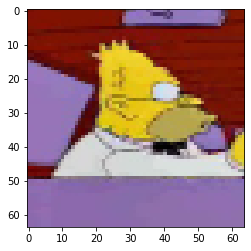

Predicted Character:abraham_grampa_simpson
Percentage of guess:0.980835


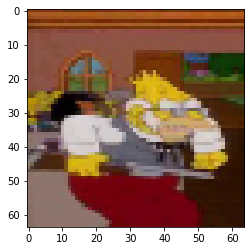

Predicted Character:abraham_grampa_simpson
Percentage of guess:0.6121203


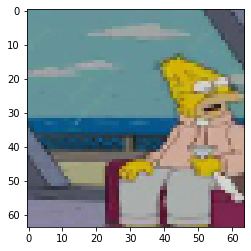

Predicted Character:bart_simpson
Percentage of guess:0.9727084


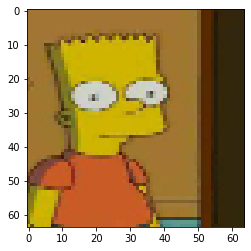

Predicted Character:charles_montgomery_burns
Percentage of guess:0.8832084


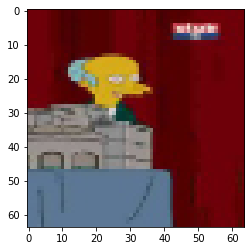

Predicted Character:kent_brockman
Percentage of guess:0.8532727


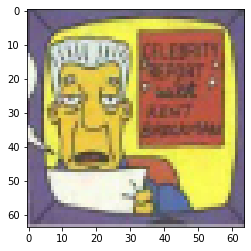

Predicted Character:lisa_simpson
Percentage of guess:0.32719976


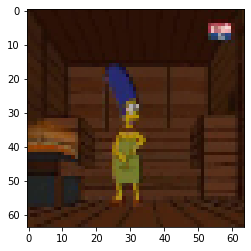

Predicted Character:kent_brockman
Percentage of guess:0.7899118


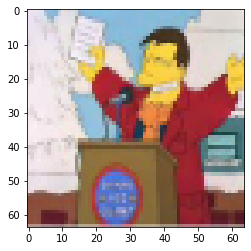

Predicted Character:krusty_the_clown
Percentage of guess:0.48721778


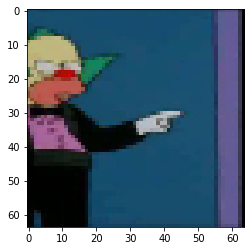

Predicted Character:sideshow_bob
Percentage of guess:0.7249897


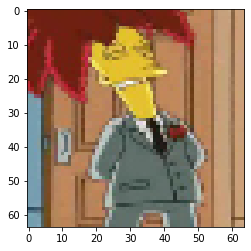

In [56]:
random_numbers = [7, 10, 43, 123, 154, 432, 643, 678, 468, 943]
for rn in random_numbers:
    print_result(result_stack[rn])